# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30);
tf.keras.backend.clear_session();

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Note: During our experiments, we will be building multiple Generators. Here is the vanila one.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,30)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size   # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Resizing images
                    image = imresize(image,(120,120)) #
                    
                    image = (image - np.min(image)) / (np.max(image) - np.min(image)) #Normalizing
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        batch_size_rem = len(folder_list)%num_batches
        
        if batch_size_rem!=0:
            batch_size = batch_size_rem
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Resizing images
                    image = imresize(image,(120,120))
                    
                    image = (image - np.min(image)) / (np.max(image) - np.min(image)) #Normalizing
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In the above generator we have handled
* Normalization
* Resizing

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = Sequential()

# 1st Layer
model.add(Conv3D(8, kernel_size=(3,3,3), strides=(1,1,1), activation='relu',padding='same', input_shape=(30,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 2nd Layer
model.add(Conv3D(16, kernel_size=(3,3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 3nd Layer
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 4rd Layer
model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())


#model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))

model.add(Dropout(0.75))

model.add(Dense(5, activation='softmax'));

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser = 'adadelta' #Tried with 'adam' as well,  but we are getting better results using 'adadelta'.
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 32)     13856     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
batch_size = 50 #experiment with the batch size
num_epochs = 32 # choose the number of epochs
print ('# batch size =', batch_size)
print ('# epochs =', num_epochs)

# batch size = 50
# epochs = 32


In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
#Fitting model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0);

Source path =  Project_data/val Source path =  Project_data/train ; batch size = 50
Epoch 1/32
; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 249s 18s/step - loss: 2.9625 - categorical_accuracy: 0.2543 - val_loss: 1.4584 - val_categorical_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 1.45838, saving model to model_init_2020-04-1309_18_53.273341/model-00001-2.96247-0.25429-1.45838-0.28000.h5
Epoch 2/32
14/14 [==============================] - 88s 6s/step - loss: 1.4593 - categorical_accuracy: 0.3729 - val_loss: 1.3468 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss improved from 1.45838 to 1.34683, saving model to model_init_2020-04-1309_18_53.273341/model-00002-1.45932-0.37286-1.34683-0.35000.h5
Epoch 3/32
14/14 [==============================] - 83s 6s/step - loss: 1.4461 - categorical_accuracy: 0.3657 - val_loss: 1.2182 - val_categorical_accuracy: 0.5800

Epoch 00003: val_loss improved from 1.34683 to 1.21817, saving model to model_init_2020-04-1309_18_53.273341/model-00003-1.44615-0.36571-1.21817-0.58000.h5
Epoch 4/32
14/14 [==============================] 

In [16]:
#Epoch 00032: val_loss improved from 0.59309 to 0.58275, saving model to model_init_2020-04-1309_18_53.273341/model-00032-0.19104-0.94143-0.58275-0.81000.h5

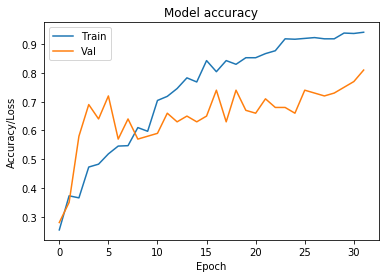

In [17]:
#Visualize the models accuracy
import matplotlib.pyplot as plt
plt.plot(model.history.history['categorical_accuracy'])
plt.plot(model.history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val','Train Loss','Val Loss'], loc='upper left')
plt.show()

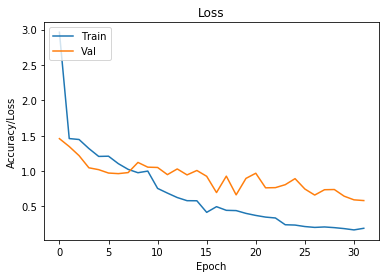

In [18]:
#plt.plot(model.history.history['categorical_accuracy'])
#plt.plot(model.history.history['val_categorical_accuracy'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val','Train Loss','Val Loss'], loc='upper left')
plt.show()

We can see at epoch 7-8, we were getting good result.

Since we are not getting good scores.Modifying the generator.

We will make it compatible for flipped and augmented images.

## GeneratorV2

In [19]:
import cv2
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return M

In [20]:
#NEW GENERATOR:
def generatorv2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,30)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size   # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            #For augmented images
            batch_data_aug = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels_aug = np.zeros((batch_size,5))
            
            #For fliped images
            batch_data_flip = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels_flip = np.zeros((batch_size,5))
            
            M = get_random_affine()
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Resizing images
                    image = imresize(image,(120,120))
                    
                    batch_data_aug[folder,idx] = (cv2.warpAffine(image, M, (image.shape[0], image.shape[1])))
                    
                    image = (image - np.min(image)) / (np.max(image) - np.min(image)) #Normalizing
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                batch_labels_aug[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                
                #There is a problem in horizotal pictures. Left->Right and RIght->Left
                if int(t[folder + (batch*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
                elif int(t[folder + (batch*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
                else:
                    batch_labels_flip[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        batch_size_rem = len(folder_list)%num_batches
        
        if batch_size_rem!=0:
            batch_size = batch_size_rem
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            #For augmented images
            batch_data_aug = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels_aug = np.zeros((batch_size,5))
            
            #For fliped images
            batch_data_flip = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels_flip = np.zeros((batch_size,5))
            
            M = get_random_affine()
            
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Resizing images
                    image = imresize(image,(120,120))
                    
                    batch_data_aug[folder,idx] = (cv2.warpAffine(image, M, (image.shape[0], image.shape[1])))
                    
                    image = (image - np.min(image)) / (np.max(image) - np.min(image)) #Normalizing
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                batch_labels_aug[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                
                #There is a problem in horizotal pictures. Left->Right and RIght->Left
                if int(t[folder + (batch*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
                elif int(t[folder + (batch*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
                else:
                    batch_labels_flip[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        

## Model

Here we will try to run same model on the new generator

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = Sequential()

# 1st Layer
model.add(Conv3D(8, kernel_size=(3,3,3), strides=(1,1,1), activation='relu',padding='same', input_shape=(30,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 2nd Layer
model.add(Conv3D(16, kernel_size=(3,3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 3nd Layer
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 4rd Layer
model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())


#model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))

model.add(Dropout(0.75))

model.add(Dense(5, activation='softmax'));

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [22]:
#learning_rate = 0.1
optimiser =  'adadelta' #'adam' #optimizers.Adam(lr=learning_rate)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 30, 30, 32)     13856     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [23]:
batch_size = 50
num_epochs = 32

In [24]:
train_generator = generatorv2(train_path, train_doc, batch_size)
val_generator = generatorv2(val_path, val_doc, batch_size)

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
#Fitting model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0);

Source path =  Project_data/val ; batch size = 50
Source path =  Project_data/train ; batch size = 50
Epoch 1/32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 105s 7s/step - loss: 2.7115 - categorical_accuracy: 0.2357 - val_loss: 1.4399 - val_categorical_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 1.43993, saving model to model_init_2020-04-1309_18_53.273341/model-00001-2.71145-0.23571-1.43993-0.45000.h5
Epoch 2/32
14/14 [==============================] - 90s 6s/step - loss: 1.4887 - categorical_accuracy: 0.3286 - val_loss: 1.2639 - val_categorical_accuracy: 0.4200

Epoch 00002: val_loss improved from 1.43993 to 1.26394, saving model to model_init_2020-04-1309_18_53.273341/model-00002-1.48873-0.32857-1.26394-0.42000.h5
Epoch 3/32
14/14 [==============================] - 89s 6s/step - loss: 1.3829 - categorical_accuracy: 0.3800 - val_loss: 1.3535 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 1.26394
Epoch 4/32
14/14 [==============================] - 91s 6s/step - loss: 1.4397 - categorical_accuracy: 0.3486 - val_loss: 1.2222 - val_categorical_accuracy:


Epoch 00031: val_loss did not improve from 0.39416
Epoch 32/32
14/14 [==============================] - 90s 6s/step - loss: 0.1950 - categorical_accuracy: 0.9129 - val_loss: 0.3961 - val_categorical_accuracy: 0.8600

Epoch 00032: val_loss did not improve from 0.39416


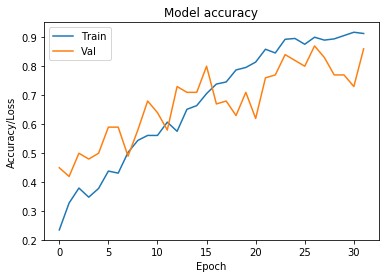

In [28]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['categorical_accuracy'])
plt.plot(model.history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val','Train Loss','Val Loss'], loc='upper left')
plt.show()

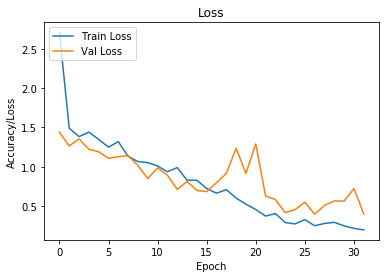

In [30]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss','Val Loss'], loc='upper left')
plt.show()

We can see, using the new generator, we got slighlt better result. So going forward, we will use this generator.

Till now we have seen, how we can work on image sequence using Conv3D CNN.

We know that RNN works good for sequential data and this time we will use Transfer Learning using Mobilenet.

## Transfer Learning  (CNN+ RNN)

In [32]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50,mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_mobile_net_gru = Sequential()
model_mobile_net_gru.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))
        
        
for layer in model_mobile_net_gru.layers:
    layer.trainable = True    
        
#model_mobile_net_gru.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'))       
model_mobile_net_gru.add(TimeDistributed(BatchNormalization()))
model_mobile_net_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mobile_net_gru.add(TimeDistributed(Flatten()))

model_mobile_net_gru.add(GRU(256))
model_mobile_net_gru.add(Dropout(0.25))
        
model_mobile_net_gru.add(Dense(128,activation='relu'))
model_mobile_net_gru.add(Dropout(0.5))
        
model_mobile_net_gru.add(Dense(5, activation='softmax'))

optimiser = 'adadelta'
model_mobile_net_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy']);

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [33]:
model_mobile_net_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               983808    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
__________

In [34]:
batch_size = 10
num_epochs = 20

train_generator = generatorv2(train_path, train_doc, batch_size)
val_generator = generatorv2(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    

model_mobile_net_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


64/67 [===========================>..] - ETA: 4s - loss: 1.2324 - categorical_accuracy: 0.5375

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 98s 1s/step - loss: 1.2303 - categorical_accuracy: 0.5329 - val_loss: 0.8419 - val_categorical_accuracy: 0.6700

Epoch 00001: val_loss improved from inf to 0.84187, saving model to model_init_2020-04-1309_18_53.273341/model-00001-1.22135-0.53846-0.84187-0.67000.h5
Epoch 2/20
67/67 [==============================] - 31s 457ms/step - loss: 1.2918 - categorical_accuracy: 0.5124 - val_loss: 1.2705 - val_categorical_accuracy: 0.5400

Epoch 00002: val_loss did not improve from 0.84187
Epoch 3/20
67/67 [==============================] - 33s 486ms/step - loss: 1.1205 - categorical_accuracy: 0.5821 - val_loss: 0.6097 - val_categorical_accuracy: 0.7800

Epoch 00003: val_loss improved from 0.84187 to 0.60974, saving model to model_init_2020-04-1309_18_53.273341/model-00003-1.12047-0.58209-0.60974-0.78000.h5
Epoch 4/20
67/67 [==============================] - 33s 496ms/step - loss: 0.8894 - categorical_accuracy: 0.6617 - val_loss: 0.9369 - val_categorical_a

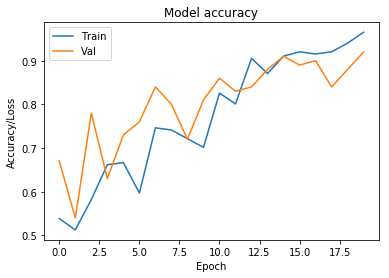

In [35]:
#Visualize the models accuracy
plt.plot(model_mobile_net_gru.history.history['categorical_accuracy'])
plt.plot(model_mobile_net_gru.history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

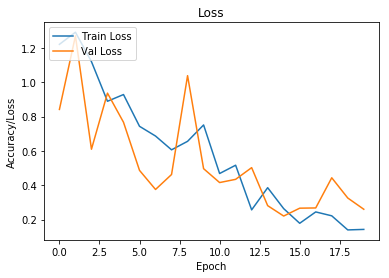

In [36]:
plt.plot(model_mobile_net_gru.history.history['loss'])
plt.plot(model_mobile_net_gru.history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss','Val Loss'], loc='upper left')
plt.show()

In [ ]:
#Epoch 00015: val_loss improved from 0.28087 to 0.22025, saving model to model_init_2020-04-1309_18_53.273341/model-00015-0.26339-0.91045-0.22025-0.91000.h5

#### Below are some of the learnings:
* We have done multiple iterations for Conv3D model.
* We tried models with 3 layers (8,16,64) but those models were underfitted.
* Models with 4 layers performed good.
* We tried to increase dropout rates for over fitted models.
* We have used 'adam' and 'adadelta' optimiser and we found 'adadelta' was giving good result.
* On local machine, we start with 20-30 batchsize (due to limited GPU resource)
* On Nimblebox, we took batchsize 50 and it was handled quite well.
* We made two data generators. The modified generator, was handling filled and augmented images.
* For CNN+RNN, we used Transfer learning using MobileNet network and the results was great.
* We again train the MobileNet on our data.
* Our final model would be CNN+RNN.